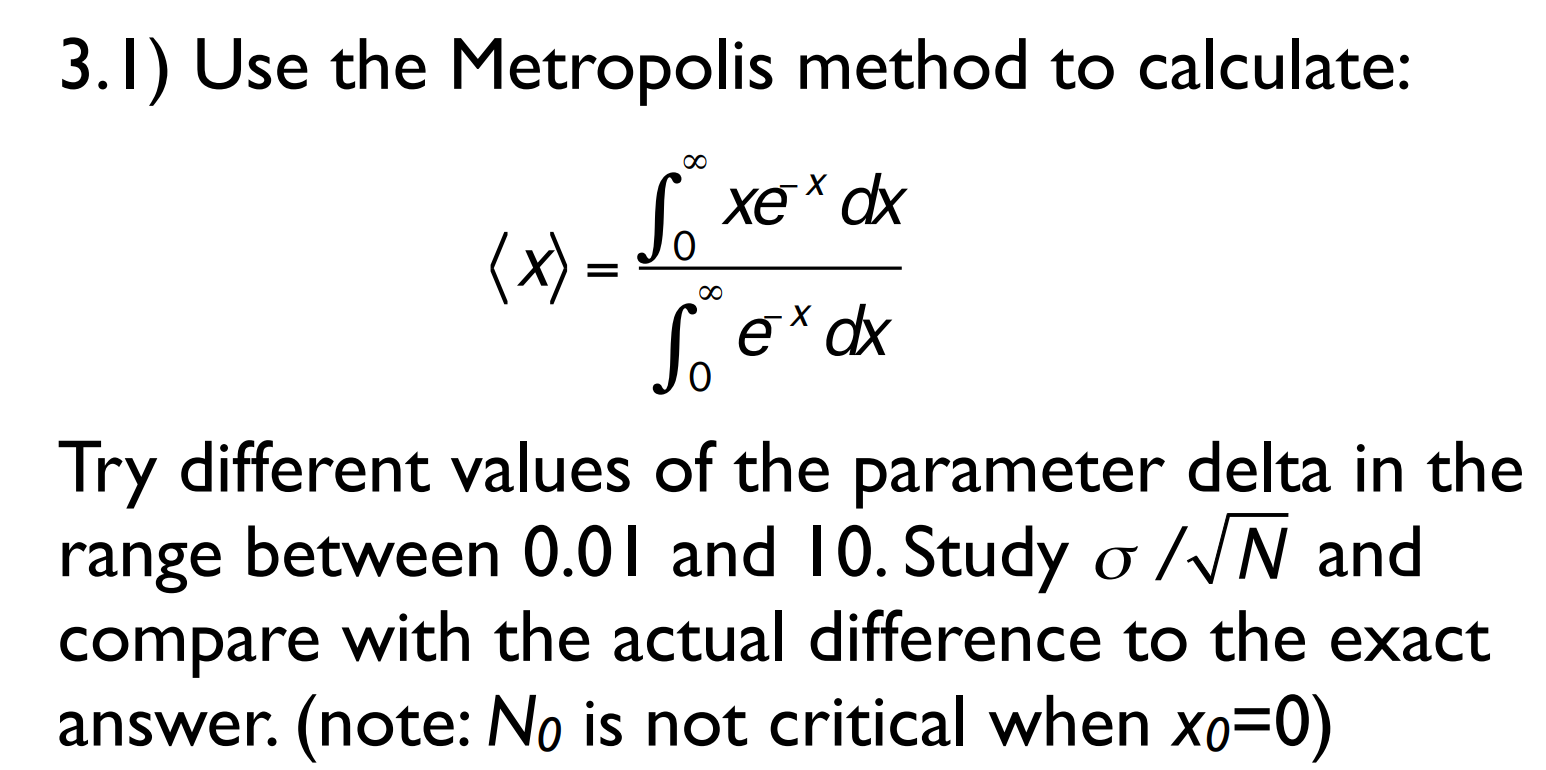

Exact answer = 1, right?


In [ ]:
"""
Code skeleton:

Choose initial trial point xj = xi + di where di is a uniform random number [-delta, delta]

Givet P = lambda function of x

If w=P(xj)/P(xi) > r where r is a random number [0,1] (uniform)
    then x_i+1 = x_j
else x_i+1 = x_i

repeat until enough points, N+N0 times.

<f> approx 1/N sum i=n0->N+N0 f(x_i)

Successive points are correlated -> statistical error > sigma/sqrt(N)
"""

'\nCode skeleton:\n\nChoose initial trial point xj = xi + di where di is a uniform random number [-delta, delta]\n\nGivet P = lambda function of x\n\nIf w=P(xj)/P(xi) > r where r is a random number [0,1] (uniform)\n    then x_i+1 = x_j\nelse x_i+1 = x_i\n\nrepeat until enough points, N+N0 times.\n\n<f> approx 1/N sum i=n0->N+N0 f(x_i)\n\nSuccessive points are correlated -> statistical error > sigma/sqrt(N)\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def metropolis_algoritm(initial_condition=0, 
                        distribution=lambda x: np.e**(-x) if x >= 0 else 0,
                        function=lambda x: x,
                        N=1000, N0=1000,
                        delta=1):
    X = np.zeros(N+N0)
    random_r = np.random.random(N+N0)
    random_d = np.random.uniform(-delta,delta,N+N0)

    def superman(ri, di, xi=initial_condition, P=distribution):
        xj = xi + di
        w = P(xj)/P(xi)
        if w > ri:
            return xj
        else:
            return xi
    
    X[0] = initial_condition
    for i in range(1,N+N0):
        X[i] = superman(random_r[i], random_d[i], X[i-1])

    FX = np.fromiter(map(function, X), float)
    f_mean = np.mean(FX[-N:])
    # print(f"<f> = {f_mean} \n F(X) = {FX}")
    f_std_sqrtN = np.std(FX[-N:])/np.sqrt(N)
    return f_mean, f_std_sqrtN

In [ ]:
metropolis_algoritm(initial_condition=0, N=1000, N0=10000)

(0.7034305270656527, 0.020251797504064556)

In [ ]:
def ans1(M=500, N=1000):
    deltas = np.linspace(0.01, 10, M)
    MEANS = np.zeros(M)
    STD_sqrtN = np.zeros(M)

    for i in range(M):
        MEANS[i], STD_sqrtN[i] = metropolis_algoritm(delta=deltas[i], N=1000)
    
    # Plot STE
    plt.figure()
    plt.title("Standard error of the mean v delta | N=1000")
    plt.xlabel('Delta')
    plt.ylabel('STD/sqrt(N)')
    plt.plot(deltas, STD_sqrtN, 'o')
    plt.tight_layout()  # adapt the plot area tot the text with larger fonts
    plt.show()

    # Plot <f>
    plt.figure()
    plt.title(f"<f> v delta | N={N}")
    plt.xlabel('Delta')
    plt.ylabel('<f>')
    plt.plot(deltas, MEANS, 'o', label="Simulated value",)
    plt.plot(deltas, np.ones(M), label="Exact value")
    plt.legend()
    plt.tight_layout()  # adapt the plot area tot the text with larger fonts
    plt.show()

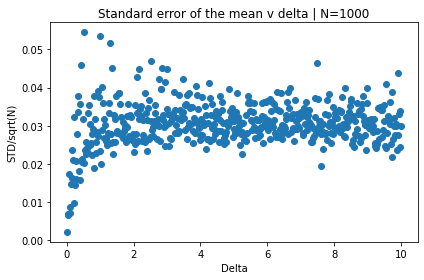

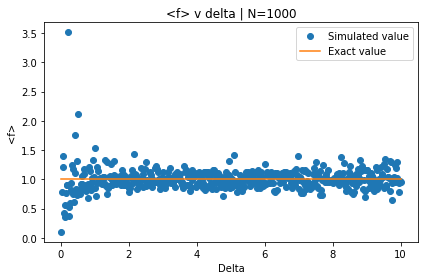

'Tolkning av resultat:\n    Standardfelet ökar med delta, men korrektheten blir sämre. Logiskt pga lågt delta leder till att xi knappt förändras.\n    Kontraintuitivt resultat though.\n    Det sanna resultatet finns nästan aldrig inom standardavvikelsen, standardavvikelsen är definitivt större än den angivna.'

In [ ]:
ans1()
"""Tolkning av resultat:
    Standardfelet ökar med delta, men korrektheten blir sämre. Logiskt pga lågt delta leder till att xi knappt förändras.
    Kontraintuitivt resultat though.
    Det sanna resultatet finns nästan aldrig inom standardavvikelsen, standardavvikelsen är definitivt större än den angivna."""

2a) Increase the timestep until things go very wrong: It goes wrong at all timesteps if particles overlap.

In [ ]:
# Python molecular dynamics simulation of particles in 2 dimensions with real time animation
# BH, OF, MP 2020-10-20, latest verson 2021-10-24

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import random as rnd

"""

    This script is rather long: sit back and try to understand its structure before jumping into coding.
    MD simulations are performed by a class (MDsimulator) that envelops both the parameters and the algorithm;
    in this way, performing several MD simulations can be easily done by just allocating more MDsimulator
    objects instead of changing global variables and/or writing duplicates.

    You are asked to implement two things:
    - pair force and potential calculation and
    - temperature coupling.
    The latter is encapsulated into the class, so make sure you are modifying the variables and using the
    parameters of the class (the one you can access via 'self.variable_name' or 'self.function_name()').

"""

# Constant to obtain box dimensions given the number of particles per row 
crystal_spacing = 1.07

# Boltzmann constant
kB = 1.0

# Number of steps between heat capacity output
N_OUTPUT_HEAT_CAP = 1000

# Generate two Gaussian random numbers with standard deviation sigma, mean 0
def gaussianRandomNumbers(sigma):
    w = 2
    while (w >= 1):
        rx1 = 2 * rnd.random() - 1
        rx2 = 2 * rnd.random() - 1
        w = rx1 * rx1 + rx2 * rx2 
    w = math.sqrt(-2 * math.log(w) / w)
    return sigma * rx1 * w, sigma * rx2 * w

# Assigns Gaussian distributed velocities given an energy per particle
def thermalize(vx, vy, sqrtKineticEnergyPerParticle):
    for i in range(0, len(vx)):
        vx[i], vy[i] = gaussianRandomNumbers(sqrtKineticEnergyPerParticle)

# The pair potential
def pairEnergy(r):
    # TODO
    # Implement the pair energy calculation here!
    s = 1
    e0 = 1
    V = 4*e0*(s**12*r**-12- s**6*r**-6)
    return V

# The pair force              
def pairForce(r):
    # TODO
    # Implement the pair force calculation here!
    s = 1
    e0 = 1
    F = -4*e0*(6*s**6*r**-7 - 12*s**12*r**-13)
    return F

# Calculate the shortest periodic distance, unit cell [0,Lx],[0,Ly]
# Returns the difference along x, along y and the distance
# This code assumes all particles are within [0,Lx],[0,Ly]
def pbc_dist(x1, y1, x2, y2, Lx, Ly):
    dx = x1 - x2
    dy = y1 - y2
    while dx < -0.5*Lx:
        dx += Lx
    while dx > 0.5*Lx:
        dx -= Lx
    while dy < -0.5*Ly:
        dy += Ly
    while dy > 0.5*Ly:
        dy -= Ly
    return dx, dy, math.sqrt(dx*dx + dy*dy)

class MDsimulator:

    """
        This class encapsulates the whole MD simulation algorithm
    """

    def __init__(self, 
        n = 24,
        L = 6.7,
        mass = 1.0, 
        numPerRow = 6, 
        T = 0.4, 
        dt = 0.01, 
        nsteps = 20000, 
        numStepsPerFrame = 100,
        startStepForAveraging = 100,
        andersonthermostat = 0
        ):
        
        """
            This is the class 'constructor'; if you want to try different simulations with different parameters 
            (e.g. temperature) in the same scrip, allocate another simulator by passing a different value as input
            argument. See the examples at the end of the script.
        """
        self.andersonthermostat = andersonthermostat
        # Initialize simulation parameters and box
        self.n = n
        self.mass = 1.0
        self.invmass = 1.0/mass
        self.numPerRow = numPerRow
        self.Lx = L
        self.Ly = L
        self.T = T
        self.kBT = kB*T
        self.dt = dt
        self.nsteps = nsteps
        self.numStepsPerFrame = numStepsPerFrame
        # Initialize positions, velocities and forces
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        self.fx = []
        self.fy = []
        for i in range (n):
            self.x.append(crystal_spacing*((i % numPerRow) + 0.5*(i / numPerRow)))
            self.y.append(crystal_spacing*0.87*(i/numPerRow))
            self.vx.append(0.0)
            self.vy.append(0.0)
            self.fx.append(0.0)
            self.fy.append(0.0)
        thermalize(self.vx, self.vy, np.sqrt(self.kBT/self.mass))
        # Initialize containers for energies
        self.sumEpot  = 0
        self.sumEpot2 = 0
        self.sumPV    = 0
        self.outt = []
        self.ekinList = []
        self.epotList = []
        self.etotList = []
        self.pvList = []
        self.startStepForAveraging = startStepForAveraging
        self.step = 0
        self.Epot = 0
        self.Ekin = 0
        self.PV = 0
        self.Cv = 0
        # Initialize figure for animation
        # self.fig = plt.figure()
        # self.ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

    def clear_energy_potential(self) :
        
        """
            Clear the temporary variables storing potential and kinetic energy
            Resets forces to zero
        """
        
        self.Epot = 0
        self.Ekin = 0
        for i in range(0, self.n):
            self.fx[i] = 0
            self.fy[i] = 0

    def update_forces(self) :

        """
            Updates forces and potential energy using functions
            pairEnergy and pairForce (which you coded above...)
            Returns the virial: 1/2 sum f*r
        """

        sum_f_times_r = 0
        for i in range(self.n):
            for j in range(i+1,self.n):
                dx, dy, r = pbc_dist(self.x[i],self.y[i],self.x[j],self.y[j],self.Lx,self.Ly)
                self.Epot  += pairEnergy(r)
                fij = pairForce(r)
                self.fx[i] += fij * dx / r
                self.fy[i] += fij * dy / r
                self.fx[j] -= fij * dx / r
                self.fy[j] -= fij * dy / r
                sum_f_times_r += fij * r
                
        # Here we divide by 4 instead of 2 because we double-counted the forces
        return -sum_f_times_r / 4
    
    def propagate(self) :

        """
            Performs an Hamiltonian propagation step and
            rescales velocities to match the input temperature 
            (THE LATTER YOU NEED TO IMPLEMENT!)
        """

        for i in range(0,self.n):
            # At the first step we alread have the "full step" velocity
            if self.step > 0:
                # Update the velocities with a half step
                self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
                self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt

            # TODO
            # When temperature coupling, modify the velocity of one or more particles here

            # Add the kinetic energy of particle i to the total
            self.Ekin += 0.5*self.mass*(self.vx[i]*self.vx[i] + self.vy[i]*self.vy[i])
            # Update the velocities with a half step
            self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
            self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt
            # Update the coordinates
            self.x[i] += self.vx[i] * self.dt
            self.y[i] += self.vy[i] * self.dt
            # Apply p.c.b. and put particles back in the unit cell
            self.x[i] = self.x[i] % self.Lx
            self.y[i] = self.y[i] % self.Ly

    def md_step(self) :

        """
            Performs a full MD step
            (computes forces, updates positions/velocities)
        """

        # This function performs one MD integration step
        self.clear_energy_potential()
        virial = self.update_forces()
        self.propagate()
        self.PV = 2 * (self.Ekin - virial)
        # Start averaging only after some initial spin-up time
        if self.step > self.startStepForAveraging:
            self.sumEpot  += self.Epot
            self.sumEpot2 += self.Epot * self.Epot
            self.sumPV    += self.PV
        
        if self.andersonthermostat > 0 and self.step%self.andersonthermostat == 0:
            thermalize(self.vx, self.vy, np.sqrt(self.kBT/self.mass))
        
        self.step += 1

    def integrate_some_steps(self, framenr=None) :

        """
            Performs MD steps in a prescribed time window
            Stores energies and heat capacity
        """

        for j in range(self.numStepsPerFrame) :
            self.md_step()
        t = self.step*self.dt
        self.outt.append(t)
        self.ekinList.append(self.Ekin)
        self.epotList.append(self.Epot)
        self.etotList.append(self.Epot + self.Ekin)
        self.pvList.append(self.PV) 
        if self.step >= self.startStepForAveraging and self.step % N_OUTPUT_HEAT_CAP == 0:
            EpotAv  = self.sumEpot/(self.step + 1 - self.startStepForAveraging)
            Epot2Av = self.sumEpot2/(self.step + 1 - self.startStepForAveraging)
            self.Cv = (Epot2Av - EpotAv * EpotAv) / (self.kBT * self.T)
            pvAv    = self.sumPV/(self.step + 1 - self.startStepForAveraging)
            print('time', t, '<Cv> =', self.Cv, "<P>V =", pvAv)

    def snapshot(self, framenr=None) :

        """
            This is an 'auxillary' function needed by animation.FuncAnimation
            in order to show the animation of the 2D Lennard-Jones system
        """

        self.integrate_some_steps(framenr)
        return self.ax.scatter(self.x, self.y, s=1500, marker='o', c="r"),

    def simulate(self) :

        """
            Performs the whole MD simulation
            If the total number of steps is not divisible by the frame size, then
            the simulation will run for nsteps-(nsteps%numStepsPerFrame) steps
        """
    
        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for "+str(nn*self.numStepsPerFrame)+" steps ...")
        for i in range(nn) :
            self.integrate_some_steps()
                
    def simulate_animate(self) :

        """
            Performs the whole MD simulation, while producing and showing the
            animation of the molecular system
            CAREFUL! This will slow down the script execution considerably
        """

        # Initialize figure for animation
        self.fig = plt.figure()
        self.ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for "+str(nn*self.numStepsPerFrame)+" steps ...") 
        anim = animation.FuncAnimation(self.fig, self.snapshot,
            frames=nn, interval=50, blit=True, repeat=False)
        plt.show()  # show the animation
        # You may want to (un)comment the following 'waitforbuttonpress', depending on your environment
        # plt.waitforbuttonpress(timeout=20)

    def plot_energy(self) :
        
        """
            Plots kinetic, potential and total energy over time
        """
        
        plt.figure()
        plt.xlabel('time')
        plt.ylabel('energy')
        plt.plot(self.outt, self.ekinList, self.outt, self.epotList, self.outt, self.etotList, self.outt, self.pvList)
        plt.legend( ('Ekin','Epot','Etot','PV') )
        plt.show()

In [ ]:
def a2(M=30):
    nsteps = 1000
    Etots = np.zeros(M)
    dts = np.logspace(-3,0,M)
    for i in range(M):
        simulator = MDsimulator(T=1, nsteps=nsteps, dt=dts[i], startStepForAveraging=0)
        simulator.simulate()
        Etots[i] = abs(simulator.etotList[-1] - simulator.etotList[0])
        print(f"{i}: Etots=[{simulator.etotList[0]}, ..., {simulator.etotList[-1]}]")


    return dts, Etots

def a22(M=30):
    nsteps = 10000
    Etots = np.zeros(M)
    dts = np.logspace(-3,-1.8,M)
    for i in range(M):
        simulator = MDsimulator(T=1, nsteps=nsteps, dt=dts[i], startStepForAveraging=0)
        simulator.simulate()
        Etots[i] = abs(simulator.etotList[-1] - simulator.etotList[0])
        print(f"{i}: Etots=[{simulator.etotList[0]}, ..., {simulator.etotList[-1]}]")


    return dts, Etots

In [ ]:
Dts2a, Etots2a = a2(M=30)

T=1, integrating for 1000 steps ...
time 1.0 <Cv> = 39.375594173878426 <P>V = 18.63969616926024
0: Etots=[-24.62192674911002, ..., -24.621389457011368]
T=1, integrating for 1000 steps ...
time 1.2689610031679222 <Cv> = 22.80391108980257 <P>V = 39.16443874327083
1: Etots=[-24.037524984027176, ..., -24.037561146190463]
T=1, integrating for 1000 steps ...
time 1.6102620275609394 <Cv> = 28.289902984768105 <P>V = 37.72578870002552
2: Etots=[-23.544183682508862, ..., -23.543906996115993]
T=1, integrating for 1000 steps ...
time 2.0433597178569416 <Cv> = 26.55744960721995 <P>V = 45.607247097987305
3: Etots=[-17.302659794188934, ..., -17.302101088305534]
T=1, integrating for 1000 steps ...
time 2.5929437974046667 <Cv> = 20.10103769322177 <P>V = 59.430941032628084
4: Etots=[-14.605958366304144, ..., -14.604946883769497]
T=1, integrating for 1000 steps ...
time 3.2903445623126677 <Cv> = 22.299910212424265 <P>V = 45.05209885721986
5: Etots=[-15.762689570625188, ..., -15.76283106105139]
T=1, integ

In [ ]:
Dts2a2, Etots2a2 = a22(M=30)

T=1, integrating for 10000 steps ...
time 1.0 <Cv> = 24.09796571267043 <P>V = 29.57167859854025
time 2.0 <Cv> = 23.509209211115603 <P>V = 5.116596047889824
time 3.0 <Cv> = 16.792106133428888 <P>V = 2.3212083723924177
time 4.0 <Cv> = 12.839777536056772 <P>V = 6.958633706487112
time 5.0 <Cv> = 10.767677333982192 <P>V = 6.538563265897483
time 6.0 <Cv> = 9.231530587211182 <P>V = 6.477361571740494
time 7.0 <Cv> = 8.5933238612472 <P>V = 4.917915101604519
time 8.0 <Cv> = 8.116815014717986 <P>V = 3.952881522173318
time 9.0 <Cv> = 7.641691573503749 <P>V = 6.000734691150913
time 10.0 <Cv> = 7.141089918036869 <P>V = 6.621846315680471
0: Etots=[-29.694159096127912, ..., -29.69367536951283]
T=1, integrating for 10000 steps ...
time 1.0999661242110876 <Cv> = 32.41926229045521 <P>V = 14.638837198830142
time 2.1999322484221753 <Cv> = 24.529906353373235 <P>V = 12.163628515875953
time 3.2998983726332627 <Cv> = 20.51440852123619 <P>V = 8.217937077694565
time 4.3998644968443505 <Cv> = 16.032375731530237 <

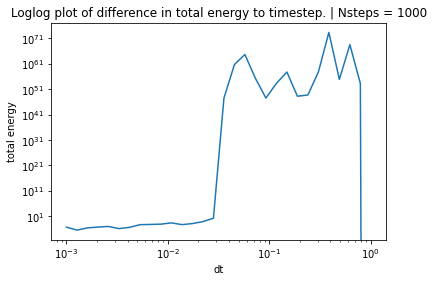

Breaks at around dt = 0.036


In [ ]:
plt.figure()
plt.title('Loglog plot of difference in total energy to timestep. | Nsteps = 1000')
plt.xlabel('dt')
plt.ylabel('total energy')
# plt.plot(Dts2a, Etots2a)
plt.loglog(Dts2a, Etots2a)
plt.show()

for i in range(len(Dts2a)):
    if Etots2a[i] > 100:
        print(f"Breaks at around dt = {Dts2a[i]:.3f}")
        break

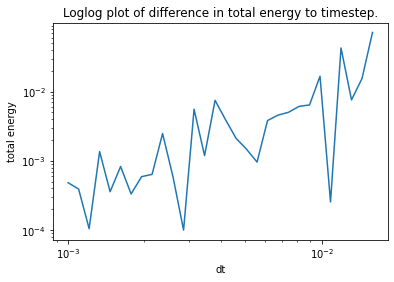

[0.001      0.00109997 0.00120993 0.00133088 0.00146392 0.00161026
 0.00177123 0.0019483  0.00214306 0.00235729 0.00259294 0.00285215
 0.00313727 0.00345089 0.00379586 0.00417532 0.00459271 0.00505182
 0.00555684 0.00611233 0.00672336 0.00739547 0.00813476 0.00894796
 0.00984246 0.01082637 0.01190864 0.0130991  0.01440856 0.01584893]
Breaks at around dt = 0.036


In [ ]:
plt.figure()
plt.title('Loglog plot of difference in total energy to timestep.')
plt.xlabel('dt')
plt.ylabel('total energy')
# plt.plot(Dts2a, Etots2a)
plt.loglog(Dts2a2, Etots2a2)
plt.show()
print(Dts2a2)

for i in range(len(Dts2a)):
    if Etots2a[i] > 100:
        print(f"Breaks at around dt = {Dts2a[i]:.3f}")
        break

In [ ]:
def b2():
    simulator = MDsimulator(T=0.2)#, T=1, n=3, numPerRow=1)
    simulator.simulate()
    return simulator

simb2 = b2()

T=0.2, integrating for 20000 steps ...
time 10.0 <Cv> = 178.35161565169525 <P>V = -1.8550090421969845
time 20.0 <Cv> = 109.22093214046525 <P>V = -3.8696273868123385
time 30.0 <Cv> = 85.29374761197913 <P>V = -3.9169406655505554
time 40.0 <Cv> = 78.60580741754573 <P>V = -2.6663396839924305
time 50.0 <Cv> = 70.06296061119882 <P>V = -1.0755685573611855
time 60.0 <Cv> = 65.0600915360087 <P>V = -1.5599575841024764
time 70.0 <Cv> = 62.00944811087082 <P>V = -1.0530740821827211
time 80.0 <Cv> = 59.32321341259693 <P>V = -0.6794397826444739
time 90.0 <Cv> = 57.29851986786797 <P>V = -0.9203884196114532
time 100.0 <Cv> = 55.597384586326356 <P>V = -1.1983802825044434
time 110.0 <Cv> = 53.38827615395302 <P>V = -1.3969076242172171
time 120.0 <Cv> = 51.2462188365589 <P>V = -1.5234202315988123
time 130.0 <Cv> = 50.075103815686354 <P>V = -1.5199710537206037
time 140.0 <Cv> = 49.36232823480395 <P>V = -1.2046479183641003
time 150.0 <Cv> = 48.62362945839322 <P>V = -1.2103232788923153
time 160.0 <Cv> = 48.43

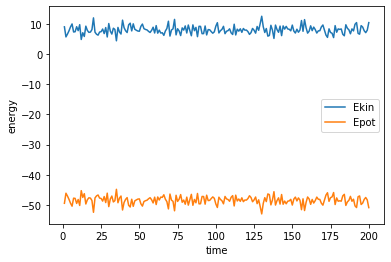

In [ ]:
plt.figure()
plt.title("Potential and Kinetic energy")
plt.xlabel('time')
plt.ylabel('energy')
plt.plot(simb2.outt, simb2.ekinList, simb2.outt, simb2.epotList)
plt.legend( ('Ekin','Epot') )
plt.show()

In [ ]:
def c2():
    """Ingen märkbar skilland i energidiagrammet men partiklarna tycks stanna tillsammans när de thermalizeras för T=0.2, men inte T=1.
    Vad borde hända? De borde spridas? Skulle vara bra om jag kunde plotta skiten för sista steget."""
    sim1 = MDsimulator(dt=0.01, andersonthermostat=1000, T=1, numStepsPerFrame=1000, nsteps=100000)
    sim1.simulate()

    sim2 = MDsimulator(dt=0.01, andersonthermostat=1000, T=0.2, numStepsPerFrame=1000, nsteps=100000)
    sim2.simulate()
    
    return sim1, sim2

sc2t1, sc2t02 = c2()

T=1, integrating for 100000 steps ...
time 10.0 <Cv> = 6.4514665029671505 <P>V = 28.860614893715333
time 20.0 <Cv> = 7.95168016835305 <P>V = 47.45367414513779
time 30.0 <Cv> = 6.590797705849354 <P>V = 44.18644234433035
time 40.0 <Cv> = 6.358499051364106 <P>V = 45.983546065222455
time 50.0 <Cv> = 6.947052819527926 <P>V = 49.51910183740859
time 60.0 <Cv> = 7.838280279270748 <P>V = 47.58828591651771
time 70.0 <Cv> = 10.236768917947984 <P>V = 54.47777238532533
time 80.0 <Cv> = 10.23709611034542 <P>V = 55.17709499338035
time 90.0 <Cv> = 9.73896938793905 <P>V = 54.58322086404217
time 100.0 <Cv> = 10.103389822341569 <P>V = 57.81615254056034
time 110.0 <Cv> = 9.553078533180042 <P>V = 57.16213733777308
time 120.0 <Cv> = 9.297553056992001 <P>V = 54.60280246155492
time 130.0 <Cv> = 8.99619907069382 <P>V = 54.93501296929889
time 140.0 <Cv> = 8.708831475228408 <P>V = 54.866364616743176
time 150.0 <Cv> = 8.768860323341414 <P>V = 53.31575878988446
time 160.0 <Cv> = 8.579308278384588 <P>V = 51.3976429

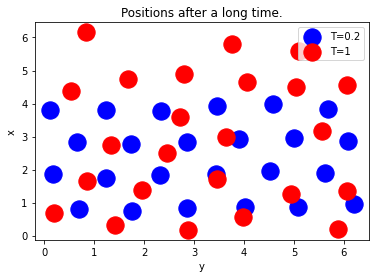

' As we can see the positions for T=0.2 are ordered while T=1 are spread out.\n    Physics reason? No idea.'

In [ ]:
plt.figure()
plt.title('Positions after a long time.')
plt.xlabel('y')
plt.ylabel('x')
plt.scatter(sc2t02.x, sc2t02.y, s=300, marker='o', c="b", label="T=0.2")
plt.scatter(sc2t1.x, sc2t1.y, s=300, marker='o', c="r", label="T=1")
plt.legend()
plt.show()

""" As we can see the positions for T=0.2 are ordered while T=1 are spread out.
    Physics reason? No idea."""

In [ ]:
def d2():
    """ Heat capacity = cv for T in [0.2:1]
        Wrong equation for Cv?? Multiply by T^-1"""
    temperature_values = np.linspace(0.2,1,10)
    cv_values = []
    ave_energy_values = []
    for TT in temperature_values :
        simulator = MDsimulator(T=TT, nsteps=10000, andersonthermostat=1000)
        simulator.simulate()
        cv_values.append(simulator.Cv)
        ave_energy_values.append(simulator.sumEpot/(simulator.step + 1 - simulator.startStepForAveraging))
    
    return temperature_values, cv_values, ave_energy_values

t2d, cv2d, avE2d = d2()

T=0.2, integrating for 10000 steps ...
time 10.0 <Cv> = 164.02978290386724 <P>V = 3.996991985141775
time 20.0 <Cv> = 152.20719494074044 <P>V = -2.3534949455168537
time 30.0 <Cv> = 139.348099926633 <P>V = -4.392446107683782
time 40.0 <Cv> = 136.80056701374494 <P>V = -5.0711314205162905
time 50.0 <Cv> = 138.71441567559938 <P>V = -7.099690276473465
time 60.0 <Cv> = 144.6323707387364 <P>V = -8.581134215933174
time 70.0 <Cv> = 167.51527770904883 <P>V = -9.850519122612207
time 80.0 <Cv> = 173.49425429936215 <P>V = -10.725061216942398
time 90.0 <Cv> = 176.73736322778947 <P>V = -11.37013465710448
time 100.0 <Cv> = 172.3990456613137 <P>V = -11.869115213898713
T=0.2888888888888889, integrating for 10000 steps ...
time 10.0 <Cv> = 73.84064161111347 <P>V = -5.381444220626992
time 20.0 <Cv> = 63.524228882021994 <P>V = -3.4443770393774313
time 30.0 <Cv> = 50.44866450068908 <P>V = -1.8620791826975165
time 40.0 <Cv> = 45.30801704952533 <P>V = -1.2940851873679622
time 50.0 <Cv> = 52.31379623440371 <P>V

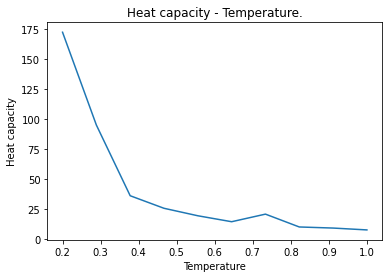

' Can you explain the\n    behavior of the heat capacity by looking at the sampled\n    configurations of the particles:\n        I Have Noo what this is bout. Shouldnt change cuz of the config right?'

In [ ]:
plt.figure()
plt.title('Heat capacity - Temperature.')
plt.xlabel('Temperature')
plt.ylabel('Heat capacity')
plt.plot(t2d, cv2d)
plt.show()

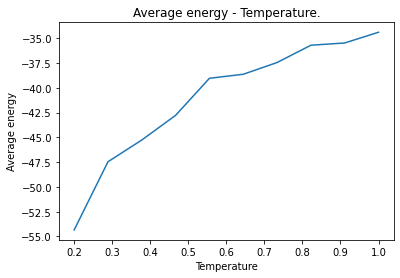

' Uppg. 2d) Temp '

In [ ]:
plt.figure()
plt.title('Average energy - Temperature.')
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.plot(t2d, avE2d)
plt.show()
""" Uppg. 2d) Temp """

In [ ]:
def e2():
    """ Pressure <P>V for different T, and L = 6.7*2
        Wrong equation for Cv?? Multiply by T^-1"""

    L = 6.7 * 2.
    temperature_values = np.linspace(0.2,1,10)
    pressure_values = []
    for TT in temperature_values :
        simulator = MDsimulator(T=TT, nsteps=30000)
        simulator.simulate()
        pressure_values.append(np.mean(simulator.pvList))
    
    return temperature_values, pressure_values

In [ ]:
t2e, p2e = e2()

T=0.2, integrating for 30000 steps ...
time 10.0 <Cv> = 161.62962310963846 <P>V = -0.29963068641845075
time 20.0 <Cv> = 106.98314002045207 <P>V = -3.461415994402595
time 30.0 <Cv> = 83.00305437636551 <P>V = -4.089499193936714
time 40.0 <Cv> = 75.11589680509586 <P>V = -3.3139437389062887
time 50.0 <Cv> = 68.85050911447478 <P>V = -3.1571778613716686
time 60.0 <Cv> = 65.26168287402923 <P>V = -2.934039220315509
time 70.0 <Cv> = 64.86427904895889 <P>V = -3.24829051845218
time 80.0 <Cv> = 63.30855224883861 <P>V = -3.7300966118649153
time 90.0 <Cv> = 61.85686311929429 <P>V = -3.270727503948576
time 100.0 <Cv> = 60.77357283685386 <P>V = -2.7073301809435435
time 110.0 <Cv> = 61.70088427965082 <P>V = -2.7834745913328196
time 120.0 <Cv> = 60.99228586519983 <P>V = -2.6387014502810007
time 130.0 <Cv> = 59.38203143223289 <P>V = -2.4914571086341586
time 140.0 <Cv> = 58.54131493426847 <P>V = -2.623432034419245
time 150.0 <Cv> = 58.54688876787576 <P>V = -2.5164018950132876
time 160.0 <Cv> = 57.98571581

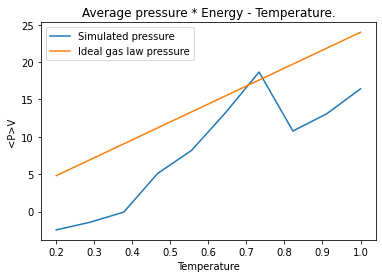

' Uppg 2e) '

In [ ]:
plt.figure()
plt.title('Average pressure * Energy - Temperature.')
plt.xlabel('Temperature')
plt.ylabel('<P>V')
plt.plot(t2e, p2e, label="Simulated pressure")
plt.plot(t2e, list(map(lambda t: 24*t, t2e)), label="Ideal gas law pressure")
plt.legend()
plt.show()
""" Uppg 2e) """

T=0.2, integrating for 30000 steps ...
time 10.0 <Cv> = 174.53613615733727 <P>V = -1.8001357333769648
time 20.0 <Cv> = 115.28998553094422 <P>V = 0.6627865876191833
time 30.0 <Cv> = 90.79490366292474 <P>V = -0.3192128495681205
time 40.0 <Cv> = 80.05415974888591 <P>V = -0.8216908942818488
time 50.0 <Cv> = 75.2098331116258 <P>V = -0.622479865910591
time 60.0 <Cv> = 70.70887859633784 <P>V = -1.0704380244692182
time 70.0 <Cv> = 65.75759766576537 <P>V = -0.9703104304911159
time 80.0 <Cv> = 64.58677545278987 <P>V = -1.0894711136225708
time 90.0 <Cv> = 63.488144905693375 <P>V = -1.1030027385690184
time 100.0 <Cv> = 63.43337235317675 <P>V = -0.4691252595738247
time 110.0 <Cv> = 61.659253756295115 <P>V = -0.3890407878147205
time 120.0 <Cv> = 60.5932028832285 <P>V = -0.6256249997219034
time 130.0 <Cv> = 60.28092322598012 <P>V = -1.0582809910248194
time 140.0 <Cv> = 57.770609622582455 <P>V = -0.8512836387639124
time 150.0 <Cv> = 57.529188560363295 <P>V = -1.2623874986009032
time 160.0 <Cv> = 57.26

NameError: ignored

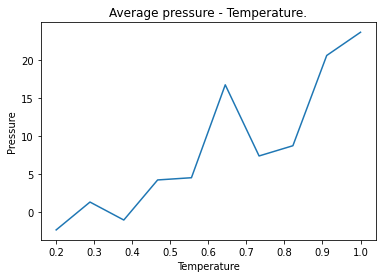

In [ ]:
def e22():
    """ Pressure <P>V for different T, and L = 6.7*2
        Wrong equation for Cv?? Multiply by T^-1"""

    L = 6.7
    temperature_values = np.linspace(0.2,1,10)
    pressure_values = []
    for TT in temperature_values :
        simulator = MDsimulator(T=TT, nsteps=30000)
        simulator.simulate()
        pressure_values.append(np.mean(simulator.pvList))
    
    return temperature_values, pressure_values

t2e2, p2e2 = e22()

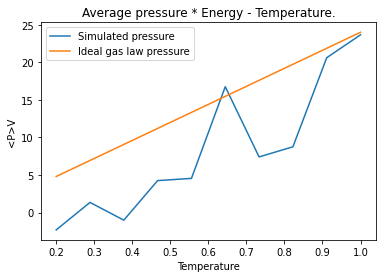

In [ ]:
plt.figure()
plt.title('Average pressure * Energy - Temperature.')
plt.xlabel('Temperature')
plt.ylabel('<P>V')
plt.plot(t2e2, p2e2, label="Simulated pressure")
plt.plot(t2e2, list(map(lambda t: 24*t, t2e2)), label="Ideal gas law pressure")
plt.legend()
plt.show()